## CSCI 5541 Project
By Sergey Barabanoff

In [1]:
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
!pip install --upgrade openai
from openai import OpenAI
client = OpenAI(api_key = 'KEY')
!pip install tiktoken
import tiktoken
encoder = tiktoken.encoding_for_model('gpt-4o')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
presentation = pd.read_parquet('/content/drive/MyDrive/EC_DataText_USA_presentation.parquet')
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)
qa = pd.read_parquet('/content/drive/MyDrive/EC_DataText_USA_qa_flow.parquet')

print('Presentation contents:')
print(presentation.info())

print('qa contents:')
print(qa.info())

Presentation contents:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211802 entries, 0 to 211801
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   companyid                       211802 non-null  float64       
 1   keydevid                        211802 non-null  float64       
 2   transcriptid                    211802 non-null  float64       
 3   headline                        211802 non-null  object        
 4   mostimportantdateutc            211802 non-null  datetime64[us]
 5   mostimportanttimeutc            211802 non-null  object        
 6   keydeveventtypeid               211802 non-null  float64       
 7   keydeveventtypename             211802 non-null  object        
 8   companyname                     211802 non-null  object        
 9   transcriptcollectiontypeid      211802 non-null  int64         
 10  transcriptcollectiontypename    2

In [3]:
unique_presentation = presentation.drop_duplicates(subset = 'headline', keep = 'first')
unique_qa = qa.drop_duplicates(subset = 'headline', keep = 'first')

merged = pd.merge(unique_presentation, unique_qa[['headline', 'qa_flow']], on = 'headline', how = 'left')
keep = ['permno', 'cusip', 'headline', 'mostimportantdateutc', 'mostimportanttimeutc', 'companyname', 'ticker', 'eom', 'presentation', 'qa_flow']
cleaned = merged[keep].dropna(subset = keep)
print(cleaned.info())
cleaned.iloc[:, :-3].head(100)

<class 'pandas.core.frame.DataFrame'>
Index: 203474 entries, 0 to 208326
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   permno                203474 non-null  float64       
 1   cusip                 203474 non-null  object        
 2   headline              203474 non-null  object        
 3   mostimportantdateutc  203474 non-null  datetime64[us]
 4   mostimportanttimeutc  203474 non-null  object        
 5   companyname           203474 non-null  object        
 6   ticker                203474 non-null  object        
 7   eom                   203474 non-null  datetime64[us]
 8   presentation          203474 non-null  object        
 9   qa_flow               203474 non-null  object        
dtypes: datetime64[us](2), float64(1), object(7)
memory usage: 17.1+ MB
None


,permno,cusip,headline,mostimportantdateutc,mostimportanttimeutc,companyname,ticker
0,80191.0,012653101,"Albemarle Corp., Q3 2007 Earnings Call, Oct-23-2007",2007-10-23,14:00:00,Albemarle Corporation,ALB
1,80191.0,012653101,"Albemarle Corp., Q4 2007 Earnings Call, Jan-29-2008",2008-01-29,14:00:00,Albemarle Corporation,ALB
2,80191.0,012653101,"Albemarle Corp., Q1 2008 Earnings Call, Apr-22-2008",2008-04-22,12:00:00,Albemarle Corporation,ALB
3,80191.0,012653101,"Albemarle Corp., Q2 2008 Earnings Call, Jul-21-2008",2008-07-21,15:00:00,Albemarle Corporation,ALB
4,80191.0,012653101,"Albemarle Corp., Q3 2008 Earnings Call, Oct-28-2008",2008-10-28,14:00:00,Albemarle Corporation,ALB
5,80191.0,012653101,"Albemarle Corp., Q4 2008 Earnings Call, Jan-27-2009",2009-01-27,15:00:00,Albemarle Corporation,ALB
6,80191.0,012653101,"Albemarle Corp., Q1 2009 Earnings Call, Apr 28, 2009",2009-04-28,15:00:00,Albemarle Corporation,ALB
7,80191.0,012653101,"Albemarle Corp., Q2 2009 Earnings Call, Jul-23-2009",2009-07-23,14:00:00,Albemarle Corporation,ALB
8,80191.0,012653101,"Albemarle Corp., Q3 2009 Earnings Call, Oct-27-2009",2009-10-27,15:00:00,Albemarle Corporation,ALB
9,80191.0,012653101,"Albemarle Corp., Q4 2009 Earnings Call, Jan 26, 2010",2010-01-26,15:00:00,Albemarle Corporation,ALB


In [5]:
# Function to separate an agent's reasoning, confidence, and prediction
def parse_output(output):
  # Get prediction about price change
  prediction_match = re.search(r'Final Prediction: \s*(Increase|Decrease|No Change)', output, re.IGNORECASE)
  prediction = prediction_match.group(1) if prediction_match else None

  # Get confidence
  confidence_match = re.search(r'Confidence[:\s]*([0-9]+(?:\.[0-9]+)?)', output, re.IGNORECASE)
  confidence = float(confidence_match.group(1)) if confidence_match else None

  # Get reasoning
  reasoning = output.split('Final Prediction:')[0].strip()

  return reasoning, prediction, confidence

In [6]:
# Single agent prompt and response
def single_agent(text, type):
  prompt = f"""
  You are a financial analyst. Your task is to analyze the following
  Earnings Call {type} transcript and predict the company's stock movement over
  the next 3 months.

  You must evaluate the transcript from three distinct perspectives:

  1. Emotion Analysis
    - Assess management tone, confidence, anxiety, enthusiasm, or tension.
    - Explain how these emotional cues affect investor sentiment and short-term stock movement.

  2. Logic & Strategy Analysis
    - Evaluate internal consistency of statements.
    - Identify contradictions, unclear reasoning, or unrealistic claims.
    - Assess the credibility of strategies and plans.
    - Explain whether management’s logic strengthens or weakens the bullish/bearish case.

  3. Fundamentals Analysis
    - Consider guidance, revenue trends, demand commentary, risks, and financial direction.
    - Identify what the numbers or business conditions imply for stock value over the next quarter.

  After explicitly analyzing all three dimensions, you must:

  - Provide a final prediction: "Increase", "Decrease", or "No Change".
  - Provide a confidence score (0 – 100).
  Keep the final answer in the following strict format:

  Final Prediction: <Increase/Decrease/No Change>
  Confidence: <0 - 100>

  Transcript:
  {text}
  """

  response = client.chat.completions.create(model = 'gpt-4o', messages = [{'role': 'user', 'content': prompt}], max_tokens = 3000)
  return response.choices[0].message.content.strip()

In [7]:
# Function for multiagent debate
def multiagent_debate(transcript, type):
  debate_transcript = ''
  rounds = 2 # Only allow 2 rounds of debate

  # Define different agents
  fundamentalist = """
  You are the fundamentalist agent. You focus exclusively on financial fundamentals:
  - Revenue direction, margins, guidance, cash flow, risks
  - Demand commentary
  - Expected valuation impact over the next 3 months

  Output:
  1. Your reasoning
  2. Final Prediction: <Increase/Decrease/No Change>
  3. Confidence: <0 - 100>
  """

  emotion = """
  You are the Emotion Analyst Agent.
  You focus exclusively on emotional and psychological cues:
  - Tone, confidence, anxiety, enthusiasm, hedging, stress markers
  - How these emotional signals shape near-term investor sentiment

  Output:
  1. Your reasoning
  2. Final Prediction: <Increase/Decrease/No Change>
  3. Confidence: <0 - 100>
  """

  logician = """
  You are the Logic and Strategy Agent.
  You focus on:
  - Internal consistency, contradictions, clarity
  - Credibility of strategy and execution
  - Realistic vs unrealistic claims
  - Whether logic strengthens the bullish or bearish case

  Output:
  1. Your reasoning
  2. Final Prediction: <Increase/Decrease/No Change>
  3. Confidence: <0 - 100>
  """

  agents = [('Fundamentalist', fundamentalist), ('Emotion Analyst', emotion), ('Logician', logician)]

  predictions = []
  confidences = []
  agent_turn_records = []

  for r in range(1, rounds + 1):
    for name, prompt in agents:
      messages = [
          {'role': 'system', 'content': prompt},
          {'role': 'user', 'content': f"""
          We are in round {r} of a multi-agent stock prediction debate.

          Here is the original earnings call {type} transcript:
          {transcript}

          Here is the debate so far (you should reference it):
          {debate_transcript}

          Now produce your next turn in the debate. Remember to output in this format:
          <Your reasoning>
          Final Prediction: <Increase/Decrease/No Change>
          Confidence: <0 - 100>
          """}]

      response = client.chat.completions.create(
          model = 'gpt-4o',
          messages = messages,
          max_tokens = 4000)

      # Get output
      agent_output = response.choices[0].message.content.strip()

      # Append to transcript
      debate_transcript += f'\n\n{name} - Round {r}: \n{agent_output}\n'

      # Store reasoning, prediction, and confidence for this turn
      reasoning, prediction, confidence = parse_output(agent_output)
      agent_turn_records.append({'agent': name, 'round': r, 'reasoning': reasoning, 'prediction': prediction, 'confidence': confidence})

  # Get each agents final prediction
  final_round_predictions = [record for record in agent_turn_records if record['round'] == rounds]
  final_predictions = [record['prediction'] for record in final_round_predictions]
  final_confidences = [record['confidence'] for record in final_round_predictions]

  # Check to see if the agents agree
  if len(set(final_predictions)) == 1:
    final_prediction = final_predictions[0]
    valid_conf = [c for c in final_confidences if c is not None]

    if len(valid_conf) == 0:
        final_confidence = None
    else:
        final_confidence = sum(valid_conf) / len(valid_conf)

    return {
        'debate_transcript': debate_transcript,
        'agent_turns': agent_turn_records,
        'final_prediction': final_prediction,
        'final_confidence': final_confidence,
        'decision': 'consensus'}

  judge_prompt = f"""
  You are the judge agent. Three specialized agents (fundamentalist, emotion analyst, and logician)
  debated the future stock direction based on an earnings call transcript. They do not all agree.

  Your job is to read the full debate transcript, weight the arguments and evidence, and then produce a final decision.

  Return:
  Final Prediction: <Increase/Decrease/No Change>
  Confidence: <0 - 100>

  Debate transcript: {debate_transcript}
  """

  # Get judges opinion
  judge_response = client.chat.completions.create(model = 'gpt-4o', messages = [{'role': 'user', 'content': judge_prompt}], max_tokens = 1500)

  judge_output = judge_response.choices[0].message.content.strip()
  _, judge_prediction, judge_confidence = parse_output(judge_output)

  debate_transcript += f'\n\nJudge: {judge_output}'

  return {
        'debate_transcript': debate_transcript,
        'agent_turns': agent_turn_records,
        'final_prediction': judge_prediction,
        'final_confidence': judge_confidence,
        'decision': 'judge'}


In [8]:
# Function to get prices for dates of interest
def load_prices(daily, permnos, dates):
  # Load CSV in chunks because it is huge
  chunks = pd.read_csv(daily, chunksize = 500000, usecols = ['PERMNO', 'date', 'PRC'])

  matched = []
  for chunk in chunks:
    chunk['date'] = chunk['date'].astype(str)
    filtered = chunk[chunk['PERMNO'].isin(permnos) & chunk['date'].isin(dates)]
    matched.append(filtered)

  return pd.concat(matched, ignore_index = True)

# Function to append prices on each date to results dataframe
def merge_prices(results_df, prices_df):
  prices_df = prices_df.rename(columns = {'PERMNO': 'permno'})

  merged = results_df.merge(prices_df, left_on = ['permno', 'date_before'], right_on = ['permno', 'date'], how = 'left').rename(columns = {'PRC': 'price_before'}).drop(columns = ['date'])
  merged = merged.merge(prices_df, left_on = ['permno', 'date_after'], right_on = ['permno', 'date'], how = 'left').rename(columns = {'PRC': 'price_after'}).drop(columns = ['date'])
  merged = merged.merge(prices_df, left_on = ['permno', 'date_3mo'], right_on = ['permno', 'date'], how = 'left').rename(columns = {'PRC': 'price_3mo'}).drop(columns = ['date'])

  return merged

# Function to shrink transcripts
def truncate(text, max_tokens = 20000):
  tokens = encoder.encode(text)
  if len(tokens) <= max_tokens:
    return text
  return encoder.decode(tokens[-max_tokens:])

In [9]:
# Function to run experiments for a list of companies
def run_experiments(permnos, cleaned_df):
  results = []
  all_dates_needed = set()

  for permno in permnos:
    print(f'Processing {permno}')

    # Filter data to get transcripts for this current company
    company_data = cleaned_df[cleaned_df['permno'] == permno].sort_values('mostimportantdateutc')

    # Loop over transcripts
    for _, row in company_data.iterrows():

      # Make predictions for both q&a and presentation
      for t in ['presentation', 'qa_flow']:

        transcript = row.get(t, None)
        if transcript is None or transcript.strip() == '':
          continue

        token_count = len(encoder.encode(transcript))
        if token_count > 20000:
          transcript = truncate(transcript, 20000)
          continue

        # Collect important dates
        event_date = pd.to_datetime(row['mostimportantdateutc'])
        date_before = (event_date - pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
        date_after = (event_date + pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
        date_3mo = (event_date + pd.DateOffset(months = 3)).strftime('%Y-%m-%d')
        all_dates_needed.add(date_before)
        all_dates_needed.add(date_after)
        all_dates_needed.add(date_3mo)

        # Get predictions from a single agent
        output = single_agent(transcript, t)
        single_reasoning, single_prediction, single_confidence = parse_output(output)

        # Get predictions from multi agent debate
        mad_output = multiagent_debate(transcript, t)

        # Build results row
        initial_row = {
            'permno': permno,
            'event_date': event_date.strftime('%Y-%m-%d'),
            'ticker': row['ticker'],
            't': t,
            'single_reasoning': single_reasoning,
            'single_prediction': single_prediction,
            'single_confidence': single_confidence,
            'mad_transcript': mad_output['debate_transcript'],
            'mad_final_prediction': mad_output['final_prediction'],
            'mad_final_confidence': mad_output['final_confidence'],
            'mad_decision': mad_output['decision'],
            'date_before': date_before,
            'date_after': date_after,
            'date_3mo': date_3mo
        }

        # Append columns for individual turns
        for turn in mad_output['agent_turns']:
          agent = turn['agent']
          round = turn['round']
          prefix = f'{agent.replace(" ", "_")}_round_{round}'

          # Build each column
          initial_row[f'{prefix}_reasoning'] = turn['reasoning']
          initial_row[f'{prefix}_prediction'] = turn['prediction']
          initial_row[f'{prefix}_confidence'] = turn['confidence']

        # Append to results
        results.append(initial_row)

    # Create a checkpoint after each company
    permno_df = pd.DataFrame(results)
    new_rows_df = permno_df[permno_df['permno'] == permno]
    new_rows_df.to_csv('/content/drive/MyDrive/MAD_checkpoint.csv', mode = 'a', header = not os.path.exists('/content/drive/MyDrive/MAD_checkpoint.csv'), index = False)

  # Add prices and dates to results
  results_df = pd.DataFrame(results)
  results_df.to_csv('/content/drive/MyDrive/Results_Before_Pricing.csv', index = False)

  prices_df = load_prices('/content/drive/MyDrive/Daily.csv', permnos, all_dates_needed)
  results_df = merge_prices(results_df, prices_df)

  return results_df

In [11]:
# Companies of interest
# Had to be very specific to match companies accurately
company_substrings = {
    "AAPL": "apple",
    "MSFT": "microsoft",
    "NVDA": "nvidia",
    "CSCO": "cisco",
    "GOOGL": "alphabet",
    "META": "meta platforms",
    "AMZN": "amazon",
    "KO": "the coca-cola",
    "JPM": "jpmorgan",
    "TSLA": "tesla"
}

# Limit dates
cleaned['mostimportantdateutc'] = pd.to_datetime(cleaned['mostimportantdateutc'])
cleaned_2021_2022 = cleaned[
    (cleaned['mostimportantdateutc'] >= "2021-01-01") &
    (cleaned['mostimportantdateutc'] <= "2021-12-31")
].copy()

matched_companies = {}

for ticker, substr in company_substrings.items():
    mask = cleaned_2021_2022['companyname'].str.contains(substr, case = False, na = False)
    names = cleaned_2021_2022.loc[mask, 'companyname'].unique().tolist()
    matched_companies[ticker] = names

print("Matched companies:")
for t, names in matched_companies.items():
    print(f"{t}: {names}")

all_companynames = [name for names in matched_companies.values() for name in names]
permnos = (cleaned_2021_2022.loc[cleaned_2021_2022['companyname'].isin(all_companynames), 'permno'].dropna().unique().tolist())
print(permnos)
results_df = run_experiments(permnos, cleaned_2021_2023)
results_df.to_csv('/content/drive/MyDrive/CSCI5541Project.csv', index = False)
print('Saved results')

Matched companies:
NVDA: ['NVIDIA Corporation']
GOOGL: ['Alphabet Inc.']
META: ['Meta Platforms, Inc.']
JPM: ['JPMorgan Chase & Co.']
TSLA: ['Tesla, Inc.']
[14542.0, 86580.0, 47896.0, 13407.0, 93436.0]
Processing 14542.0
Processing 86580.0
Processing 47896.0
Processing 13407.0
Processing 93436.0
Saved results


In [4]:
results_df = pd.read_csv('/content/drive/MyDrive/CSCI5541Project.csv')
# Function to label data
def label_direction(delta):
  if delta > 0.005:
    return 'Increase'
  elif delta < -0.005:
    return 'Decrease'
  else:
    return 'No Change'

# Safe AUC call to ignore NaNs
def safe_auc(y_true, y_pred):
  mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
  valid_y_true = y_true[mask]
  valid_y_pred = y_pred[mask]

  dropped = len(y_true) - len(valid_y_true)

  if len(np.unique(valid_y_true)) < 2:
    return np.nan, dropped, len(y_true)

  return roc_auc_score(y_true[mask], y_pred[mask]), dropped, len(y_true)

# Safe correlation calculation to avoid nans
def safe_correlation(x, y):
  mask = (~np.isnan(x)) & (~np.isnan(y))
  dropped = len(x) - mask.sum()
  print(f'Dropped {dropped} rows for correlation')

  if mask.sum() < 2:
    return np.nan
  return np.corrcoef(x[mask], y[mask])[0, 1]

# Stock price change between earnings calls and 3 months later
results_df['3mo_change'] = (results_df['price_3mo'] - results_df['price_before']) / results_df['price_before']
results_df['true_label'] = results_df['3mo_change'].apply(label_direction)

# Encode labels
mapping = {'Increase': 1, 'No Change': 0, 'Decrease': -1}
results_df['single_label_map'] = results_df['single_prediction'].map(mapping)
results_df['mad_label_map'] = results_df['mad_final_prediction'].map(mapping)
results_df['true_label_map'] = results_df['true_label'].map(mapping)

# Get accuracies
single_accuracy = (results_df['single_label_map'] == results_df['true_label_map']).mean()
mad_accuracy = (results_df['mad_label_map'] == results_df['true_label_map']).mean()

# Calculate correlation between confidence and returns
single_correlation = safe_correlation(results_df['single_confidence'].values, abs(results_df['3mo_change']).values)
mad_correlation = safe_correlation(results_df['mad_final_confidence'].values, abs(results_df['3mo_change']).values)

# Calculate Sharpe ratios by calculating returns
def returns(predicted_label, change):
  if predicted_label == 1:
    return change
  elif predicted_label == -1:
    return -change
  else:
    return 0

# Returns per quarter
results_df['single_return'] = results_df.apply(lambda row: returns(row['single_label_map'], row['3mo_change']), axis = 1)
results_df['mad_return'] = results_df.apply(lambda row: returns(row['mad_label_map'], row['3mo_change']), axis = 1)

# Calculate returns
single_returns = results_df['single_return'].sum()
mad_returns = results_df['mad_return'].sum()

# Sharpe ratio
single_sharpe = results_df['single_return'].mean() / results_df['single_return'].std()
mad_sharpe = results_df['mad_return'].mean() / results_df['mad_return'].std()

# Calculate AUCs
results_df['binary_label'] = (results_df['true_label_map'] == 1).astype(int) # Treat increase as positive class

single_auc, single_dropped, single_total = safe_auc(results_df['binary_label'].values, results_df['single_confidence'].values)
mad_auc, mad_single, mad_total = safe_auc(results_df['binary_label'].values, results_df['mad_final_confidence'].values)
print(f'Single dropped and total: {single_dropped}, {single_total}')
print(f'MAD dropped and total: {mad_single}, {mad_total}')

# Get confidence trends per agent
results_df['fundamentalist_delta'] = results_df['Fundamentalist_round_2_confidence'] - results_df['Fundamentalist_round_1_confidence']
results_df['emotion_delta'] = results_df['Emotion_Analyst_round_2_confidence'] - results_df['Emotion_Analyst_round_1_confidence']
results_df['logician_delta'] = results_df['Logician_round_2_confidence'] - results_df['Logician_round_1_confidence']

mean_fundamentalist_change = results_df['fundamentalist_delta'].mean()
mean_emotion_change = results_df['emotion_delta'].mean()
mean_logician_change = results_df['logician_delta'].mean()

# Compare presentations vs Q&A
presentation_accuracy = np.mean(results_df.loc[results_df['t'] == 'presentation', 'mad_label_map'] == results_df.loc[results_df['t'] == 'presentation', 'true_label_map'])
qa_accuracy = np.mean(results_df.loc[results_df['t'] == 'qa_flow', 'mad_label_map'] == results_df.loc[results_df['t'] == 'qa_flow', 'true_label_map'])

presentation_auc, presentation_dropped, presentation_total = safe_auc(results_df.loc[results_df['t'] == 'presentation', 'binary_label'].values, results_df.loc[results_df['t'] == 'presentation', 'mad_final_confidence'].values)
qa_auc, qa_dropped, qa_total = safe_auc(results_df.loc[results_df['t'] == 'qa_flow', 'binary_label'].values, results_df.loc[results_df['t'] == 'qa_flow', 'mad_final_confidence'].values)
print(f'Presentation dropped and total: {presentation_dropped}, {presentation_total}')
print(f'QA dropped and total: {qa_dropped}, {qa_total}')

# Compare consensus and judge predictions
consensus_accuracy = np.mean(results_df.loc[results_df['mad_decision'] == 'consensus', 'mad_label_map'] == results_df.loc[results_df['mad_decision'] == 'consensus', 'true_label_map'])
judge_accuracy = np.mean(results_df.loc[results_df['mad_decision'] == 'judge', 'mad_label_map'] == results_df.loc[results_df['mad_decision'] == 'judge', 'true_label_map'])

consensus_auc, consensus_dropped, consensus_total = safe_auc(results_df.loc[results_df['mad_decision'] == 'consensus', 'binary_label'].values, results_df.loc[results_df['mad_decision'] == 'consensus', 'mad_final_confidence'].values)
judge_auc, judge_dropped, judged_total = safe_auc(results_df.loc[results_df['mad_decision'] == 'judge', 'binary_label'].values, results_df.loc[results_df['mad_decision'] == 'judge', 'mad_final_confidence'].values)

# Judge and consensus usage rates
consensus_usage = results_df['mad_decision'].value_counts()['consensus'] / len(results_df)
judge_usage = results_df['mad_decision'].value_counts()['judge'] / len(results_df)

# Compare agent predictions between first and second rounds
for agent in ['Fundamentalist', 'Emotion_Analyst', 'Logician']:
    for round in [1, 2]:
        column = f'{agent}_round_{round}_prediction'
        results_df[f'{agent}_round_{round}_label'] = results_df[column].map(mapping)

agent_accuracies = {}

for agent in ['Fundamentalist', 'Emotion_Analyst', 'Logician']:
    round1_acc = (results_df[f'{agent}_round_1_label'] == results_df['true_label_map']).mean()
    round2_acc = (results_df[f'{agent}_round_2_label'] == results_df['true_label_map']).mean()

    agent_accuracies[agent] = {
        'Round 1 Accuracy': round1_acc,
        'Round 2 Accuracy': round2_acc
    }

accuracy_df = pd.DataFrame(agent_accuracies).T

print(f'Class counts: {results_df['true_label'].value_counts()}')

Dropped 27 rows for correlation
Dropped 11 rows for correlation
Single dropped and total: 24, 40
MAD dropped and total: 4, 40
Presentation dropped and total: 1, 20
QA dropped and total: 3, 20
Class counts: true_label
Increase     22
Decrease     10
No Change     8
Name: count, dtype: int64


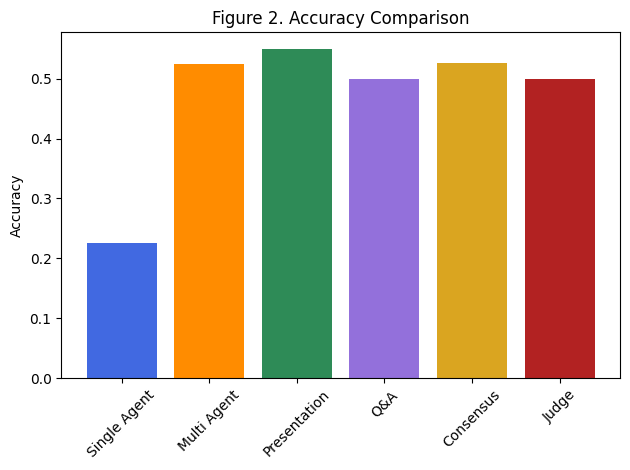

Consensus Usage Rate: 0.95
Judge Usage Rate: 0.05


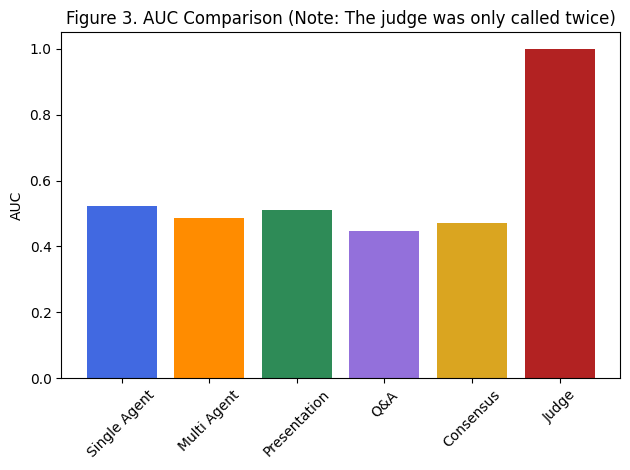

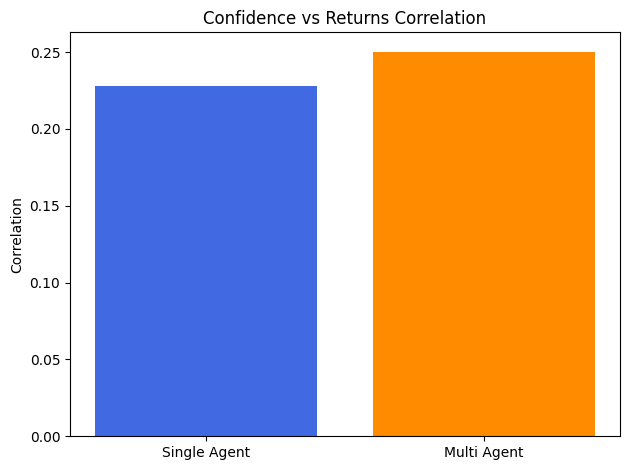

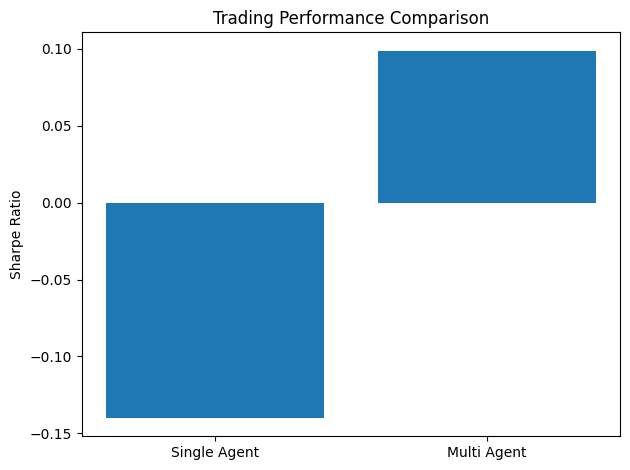

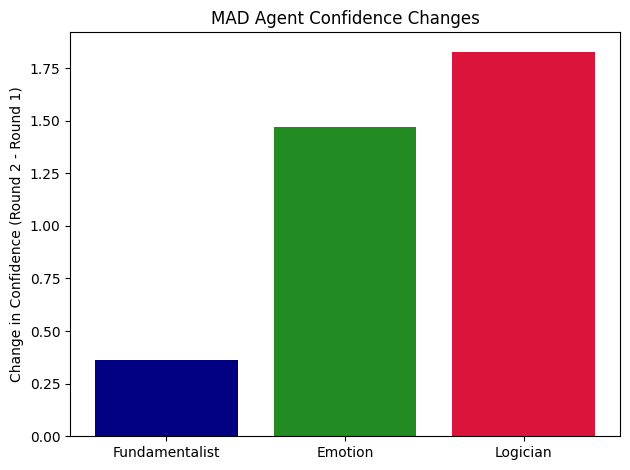

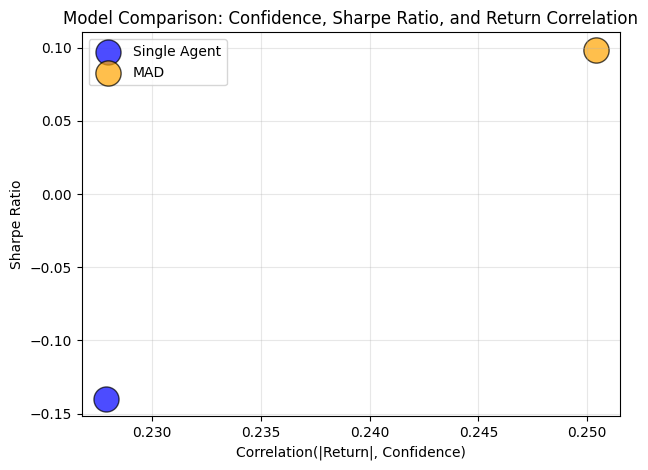

Fundamentalist Switch Rate: 0.225
Emotion Switch Rate: 0.175
Logician Switch Rate: 0.125


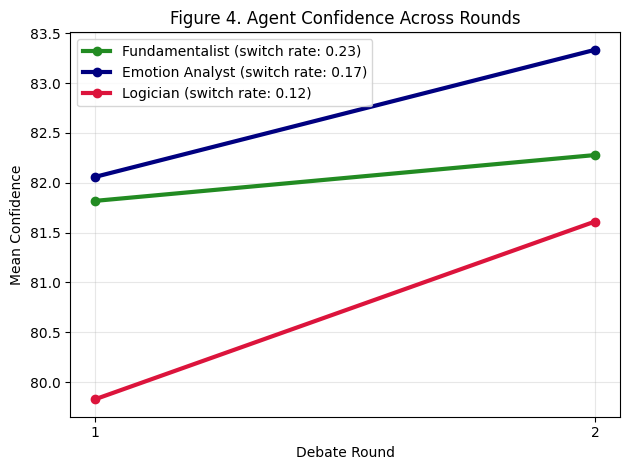

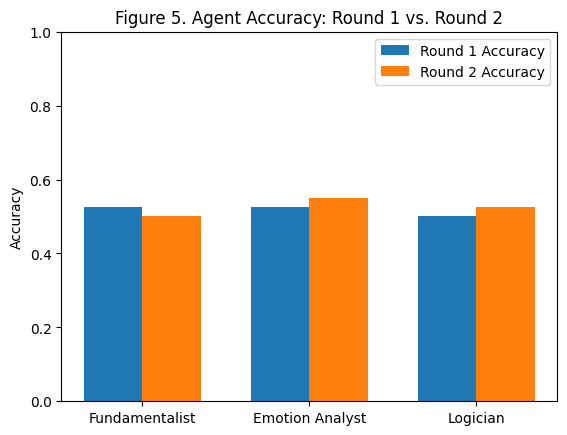

In [6]:
# Plot everything
accuracy_values = [single_accuracy, mad_accuracy, presentation_accuracy, qa_accuracy, consensus_accuracy, judge_accuracy]
accuracy_labels = ['Single Agent', 'Multi Agent', 'Presentation', 'Q&A', 'Consensus', 'Judge']
accuracy_colors = ['royalblue', 'darkorange', 'seagreen', 'mediumpurple', 'goldenrod', 'firebrick']
plt.figure()
plt.ylabel('Accuracy')
plt.title('Figure 2. Accuracy Comparison')
plt.xticks(rotation = 45)
plt.bar(accuracy_labels, accuracy_values, color = accuracy_colors)
plt.tight_layout()
plt.show()
print(f'Consensus Usage Rate: {consensus_usage}')
print(f'Judge Usage Rate: {judge_usage}')

# Plot AUC values
auc_values = [single_auc, mad_auc, presentation_auc, qa_auc, consensus_auc, judge_auc]
plt.figure()
plt.ylabel('AUC')
plt.title('Figure 3. AUC Comparison (Note: The judge was only called twice)')
plt.xticks(rotation = 45)
plt.bar(accuracy_labels, auc_values, color = accuracy_colors)
plt.tight_layout()
plt.show()

# Confidence and return metrics
correlation_values = [single_correlation, mad_correlation]
correlation_labels = ['Single Agent', 'Multi Agent']
plt.figure()
plt.ylabel('Correlation')
plt.title('Confidence vs Returns Correlation')
plt.bar(correlation_labels, correlation_values, color = accuracy_colors)
plt.tight_layout()
plt.show()

# Sharpe values
sharpe_values = [single_sharpe, mad_sharpe]
plt.figure()
plt.ylabel('Sharpe Ratio')
plt.title('Trading Performance Comparison')
plt.bar(correlation_labels, sharpe_values)
plt.tight_layout()
plt.show()

# Agent Confidence changes
agent_labels = ["Fundamentalist", "Emotion", "Logician"]
agent_deltas = [mean_fundamentalist_change, mean_emotion_change, mean_logician_change]
agent_colors = ['navy', 'forestgreen', 'crimson']
plt.figure()
plt.bar(agent_labels, agent_deltas, color = agent_colors)
plt.ylabel("Change in Confidence (Round 2 - Round 1)")
plt.title("MAD Agent Confidence Changes")
plt.tight_layout()
plt.show()

# Plot Sharpe ratios, and confidence and return correlation
methods = ["Single Agent", "MAD"]
correlations = [single_correlation, mad_correlation]
sharpes = [single_sharpe, mad_sharpe]
mean_confidences = [results_df['single_confidence'].mean(), results_df['mad_final_confidence'].mean()]

colors = ["blue", "orange"]
plt.figure()

for i in range(2):
    plt.scatter(correlations[i], sharpes[i], s = mean_confidences[i] * 4, color = colors[i], label = methods[i], alpha = 0.7, edgecolor = "black")

plt.xlabel("Correlation(|Return|, Confidence)")
plt.ylabel("Sharpe Ratio")
plt.title("Model Comparison: Confidence, Sharpe Ratio, and Return Correlation")
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# How often each agent switches votes
fundamentalist_switch_rate = np.mean(results_df['Fundamentalist_round_1_prediction'] != results_df['Fundamentalist_round_2_prediction'])
emotion_switch_rate = np.mean(results_df['Emotion_Analyst_round_1_prediction'] != results_df['Emotion_Analyst_round_2_prediction'])
logician_switch_rate = np.mean(results_df['Logician_round_1_prediction'] != results_df['Logician_round_2_prediction'])
print(f'Fundamentalist Switch Rate: {fundamentalist_switch_rate}')
print(f'Emotion Switch Rate: {emotion_switch_rate}')
print(f'Logician Switch Rate: {logician_switch_rate}')

# Plot agent confidence changes as lines
fundamentalist_round1 = results_df['Fundamentalist_round_1_confidence'].mean()
fundamentalist_round2 = results_df['Fundamentalist_round_2_confidence'].mean()

emotion_round1 = results_df['Emotion_Analyst_round_1_confidence'].mean()
emotion_round2 = results_df['Emotion_Analyst_round_2_confidence'].mean()

logician_round1 = results_df['Logician_round_1_confidence'].mean()
logician_round2 = results_df['Logician_round_2_confidence'].mean()

rounds = [1, 2]
plt.figure()

plt.plot(rounds, [fundamentalist_round1, fundamentalist_round2], marker = 'o', linewidth = 3, label = f'Fundamentalist (switch rate: {fundamentalist_switch_rate:.2f})', color = 'forestgreen')
plt.plot(rounds, [emotion_round1, emotion_round2], marker = 'o', linewidth = 3, label=f'Emotion Analyst (switch rate: {emotion_switch_rate:.2f})', color = 'navy')
plt.plot(rounds, [logician_round1, logician_round2], marker = 'o', linewidth = 3, label = f'Logician (switch rate: {logician_switch_rate:.2f})', color = 'crimson')

plt.xticks([1, 2])
plt.ylabel("Mean Confidence")
plt.xlabel("Debate Round")
plt.title("Figure 4. Agent Confidence Across Rounds")
plt.grid(alpha = 0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction changes between rounds
agents = accuracy_df.index
round1 = accuracy_df['Round 1 Accuracy'].values
round2 = accuracy_df['Round 2 Accuracy'].values

x = np.arange(len(agents))
width = 0.35

plt.figure()
plt.bar(x - width / 2, round1, width, label='Round 1 Accuracy')
plt.bar(x + width / 2, round2, width, label='Round 2 Accuracy')

plt.ylabel('Accuracy')
plt.title('Figure 5. Agent Accuracy: Round 1 vs. Round 2')
plt.xticks(x, ['Fundamentalist', 'Emotion Analyst', 'Logician'])
plt.legend()
plt.ylim(0, 1)
plt.show()